# Assignment 3 - CNN

The task is to design a CNN architecture and to train it over the MNIST digits.

The CNN has to be designed with the aim of reaching the maximum possible accuracy on the test set, with the hard constraint of a maximum of 7K learnable parameters.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch
from keras.utils.layer_utils import count_params
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_docs import plots as tfplots

Let's start with the definition of a few variables that reflect the dataset's input and output shapes.
If the dataset is missing it will be downloaded and unpacked directly by keras.

In [2]:
num_classes = 10
input_shape = (28,28,1)

(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

We can now normalize the dataset into $[0, 1]$ range and transform the categorical target value into a one-hot encoded vector with `num_classes` different values.

In [3]:
# Scale images into the [0 1] range
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

# Reshape images to (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Check size
print("Train shape: {} \nTest shape: {}".format(X_train.shape, X_test.shape))

Train shape: (60000, 28, 28, 1) 
Test shape: (10000, 28, 28, 1)


In [4]:
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

### Model
The model is composed of:

1. Input layer with a $28\times 28\times 1$ shape.
2. Convolutional2D layer with a $5\times 5$ filter size. The filter count will be detailed in the next section.
3. MaxPool2D layer with a $2\times 2$ pool size.
4. Convolutional2D layer with a $3\times 3$ filter size. The filter count will be detailed in the next section.
5. MaxPool2D layer with a $2\times 2$ pool size.
6. Flatten layer.
7. Dropout layer with a 30% chance.
8. Dense output layer with 10 classes (one for each digit) and `softmax` as the activation function.

The model uses a `categorical_crossentropy` loss function with `Adam` optimizer (default learning rate value) and tracks of `accuracy`, `precision` and `recall` metrics.

In [5]:
def build_model(hp):
    model = keras.Sequential([
        keras.Input(shape=input_shape),

        layers.Conv2D(
            hp.Int('conv_1', min_value=8, max_value=24, step=4), 
            kernel_size=(5, 5),
            activation='relu'
        ),
        layers.MaxPool2D(pool_size=(2, 2)),

        layers.Conv2D(
            hp.Int('conv_2', min_value=4, max_value=16, step=4),
            kernel_size=(3, 3),
            activation='relu'
        ),
        layers.MaxPool2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax'),
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()],
    )

    return model

### Random Search

To test the performance of different parameters I decided to use the `keras-tuner` package.
It allows to build a model with variable hyperparameters and train various combinations with a few epochs and pick the best one to perform the final training.

For the model presented above, the variable hyperparameters are in the 2nd and 4th layers. The number of filters is variable in a $[8,24]$ range for the former layer and a $[4,16]$ range for the latter.
Both variable hyperparameters has a step size of $4$.

In [6]:
tuner = RandomSearch(
    build_model,
    seed=82734,
    max_trials=7,
    objective='val_accuracy',
    executions_per_trial=3,
    directory='results',
    project_name='random_search'
)

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project results\random_search\oracle.json
INFO:tensorflow:Reloading Tuner from results\random_search\tuner0.json
Search space summary
Default search space size: 2
conv_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 32, 'step': 4, 'sampling': None}
conv_2 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 16, 'step': 4, 'sampling': None}


In [7]:
batch_size = 128
epochs = 5

tuner.search(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

INFO:tensorflow:Oracle triggered exit


After the different model combinations have been trained we can print the best ones in descending order to display the different hyperparameter choices.

In [8]:
tuner.results_summary()

Results summary
Results in results\random_search
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1: 16
conv_2: 16
Score: 0.9838888843854269
Trial summary
Hyperparameters:
conv_1: 32
conv_2: 12
Score: 0.9836666782697042
Trial summary
Hyperparameters:
conv_1: 16
conv_2: 12
Score: 0.9823055664698283
Trial summary
Hyperparameters:
conv_1: 28
conv_2: 12
Score: 0.9822777907053629
Trial summary
Hyperparameters:
conv_1: 20
conv_2: 12
Score: 0.9818333387374878
Trial summary
Hyperparameters:
conv_1: 8
conv_2: 12
Score: 0.9803333282470703
Trial summary
Hyperparameters:
conv_1: 16
conv_2: 8
Score: 0.9786111116409302
Trial summary
Hyperparameters:
conv_1: 12
conv_2: 8
Score: 0.9780555566151937
Trial summary
Hyperparameters:
conv_1: 12
conv_2: 4
Score: 0.9681110978126526
Trial summary
Hyperparameters:
conv_1: 16
conv_2: 4
Score: 0.9680277705192566


### Model Training

This resulting best model is achieved with $16$ filters in both convolutional layers.
At this stage, the model can be trained with more epochs exploiting an early stopping mechanism with a patience of $8$ and a minimum delta of $0.001$.

The model has a total of 6746 trainable parameters. This value does not exceed the assignment's constraint of 7000 parameters.

In [9]:
batch_size = 128
epochs = 100
models = {}

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    min_delta=0.001,
    restore_best_weights=True
)

hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                4

In [10]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
375/375 [==============================] - 5s 13ms/step - loss: 0.5821 - accuracy: 0.8177 - precision: 0.9245 - recall: 0.7327 - val_loss: 0.1451 - val_accuracy: 0.9597 - val_precision: 0.9699 - val_recall: 0.9495
Epoch 2/100
375/375 [==============================] - 5s 13ms/step - loss: 0.1652 - accuracy: 0.9500 - precision: 0.9598 - recall: 0.9413 - val_loss: 0.1018 - val_accuracy: 0.9700 - val_precision: 0.9749 - val_recall: 0.9653
Epoch 3/100
375/375 [==============================] - 5s 13ms/step - loss: 0.1216 - accuracy: 0.9631 - precision: 0.9687 - recall: 0.9571 - val_loss: 0.0786 - val_accuracy: 0.9779 - val_precision: 0.9819 - val_recall: 0.9745
Epoch 4/100
375/375 [==============================] - 5s 13ms/step - loss: 0.1020 - accuracy: 0.9690 - precision: 0.9736 - recall: 0.9645 - val_loss: 0.0658 - val_accuracy: 0.9810 - val_precision: 0.9842 - val_recall: 0.9784
Epoch 5/100
375/375 [==============================] - 5s 13ms/step - loss: 0.0905 - accuracy: 0

We can check the model performance during the train phase by plotting the recorded metrics and visualize the overall performance.


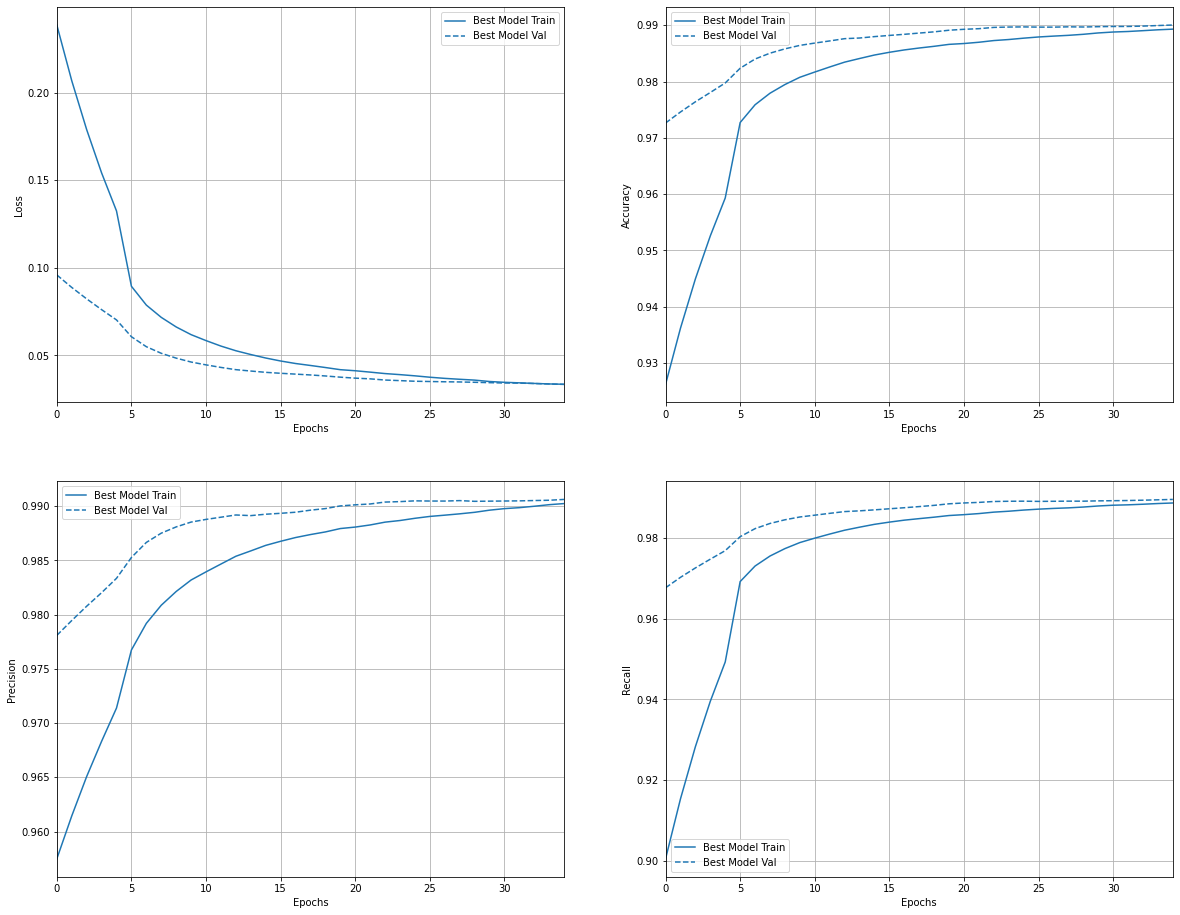

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

loss_plotter = tfplots.HistoryPlotter(metric='loss', smoothing_std=1)
acc_plotter = tfplots.HistoryPlotter(metric='accuracy', smoothing_std=1)
precision_plotter = tfplots.HistoryPlotter(metric='precision', smoothing_std=1)
recall_plotter = tfplots.HistoryPlotter(metric='recall', smoothing_std=1)

histories = {'Best model': history}

ax = plt.subplot(2, 2, 1)
loss_plotter.plot(histories)

ax = plt.subplot(2, 2, 2)
acc_plotter.plot(histories)

ax = plt.subplot(2, 2, 3)
precision_plotter.plot(histories)

ax = plt.subplot(2, 2, 4)
recall_plotter.plot(histories)

With the final model trained, we can evaluate the performance on the test set and display the results.

In [12]:
score = model.evaluate(X_test, Y_test, verbose=2)
print("Test loss: \t{} \nTest accuracy: \t{}".format(score[0], score[1]))

313/313 - 1s - loss: 0.0280 - accuracy: 0.9904 - precision: 0.9910 - recall: 0.9896
Test loss: 	0.027984680607914925 
Test accuracy: 	0.9904000163078308
